<a href="https://colab.research.google.com/github/Pathway2008/CarPrice/blob/main/stack(xgb%2Ccat%2Clgb%2Crf%2Cnn).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error

In [174]:
train = pd.read_csv('/content/drive/MyDrive/CarPrice/train.csv')
test = pd.read_csv('/content/drive/MyDrive/CarPrice/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/CarPrice/sample_submission.csv')

In [175]:
from sklearn.preprocessing import LabelEncoder

In [176]:
ordinal_features = ['브랜드', '차량모델명', '판매도시', '판매구역']

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(train[feature])
    train[feature] = le.transform(train[feature])

    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[feature] = le.transform(test[feature])

In [61]:
train.head()

,ID,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,TRAIN_00000,2018,2014,16,47,1214,12,85231,999,0,0,1,0,0,51.74
1,TRAIN_00001,2010,2006,17,20,2137,13,135000,1598,0,0,1,0,0,41.47
2,TRAIN_00002,2002,2002,9,36,785,15,255223,1796,0,0,1,0,0,17.81
3,TRAIN_00003,2006,2001,11,133,546,15,238000,2184,0,1,0,0,0,18.20
4,TRAIN_00004,2007,2007,3,25,1839,5,251000,1910,0,1,0,0,0,17.55


In [6]:
X = train.drop(['ID', '가격'], axis=1)
y = train['가격']

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [78]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [79]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [80]:
model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=10, batch_size=32)

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 22.5636 - val_loss: 14.1598
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 14.1415 - val_loss: 12.3377
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 12.9541 - val_loss: 14.0973
Epoch 4/10
1448/1448 [==============================] - 2s 2ms/step - loss: 12.4923 - val_loss: 11.5017
Epoch 5/10
1448/1448 [==============================] - 2s 2ms/step - loss: 12.2302 - val_loss: 12.4659
Epoch 6/10
1448/1448 [==============================] - 4s 3ms/step - loss: 11.8225 - val_loss: 11.0552
Epoch 7/10
1448/1448 [==============================] - 2s 2ms/step - loss: 11.7919 - val_loss: 12.8745
Epoch 8/10
1448/1448 [==============================] - 2s 2ms/step - loss: 11.6247 - val_loss: 10.8343
Epoch 9/10
1448/1448 [==============================] - 3s 2ms/step - loss: 11.5519 - val_loss: 11.7669
Epoch 10/10
1448/1448 [==============================] - 3s 2ms/

In [81]:
# 생산년도, 모델출시년도, 주행거리, 배기량 scaling
y_pred = model.predict(X_valid_scaled)

mae = mean_absolute_error(y_valid, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

362/362 [==============================] - 0s 830us/step
Mean Absolute Error (MAE): 11.47808090030571


In [75]:
# 주행거리, 배기량 scaling
y_pred = model.predict(X_valid_scaled)

mae = mean_absolute_error(y_valid, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

362/362 [==============================] - 0s 760us/step
Mean Absolute Error (MAE): 19.750413768999355


In [19]:
# all scaling
y_pred = model.predict(X_valid_scaled)

mae = mean_absolute_error(y_valid, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

362/362 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 8.859541535926828


Neural Networks + optuna

In [45]:
def objective(trial):
    # Define the hyperparameters to be tuned
    n_units = trial.suggest_int('n_units', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)

    # Build the neural network model
    model = tf.keras.Sequential([
        layers.Dense(n_units, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dense(n_units, activation='relu'),
        layers.Dense(1)
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_absolute_error')

    # Train the model with early stopping based on the validation loss
    model.fit(X_train_scaled, y_train,
              validation_data=(X_valid_scaled, y_valid),
              epochs=10,
              batch_size=32,
              callbacks=[TFKerasPruningCallback(trial, 'val_loss')])  # Enable pruning

    # Evaluate the model on the validation set
    val_loss = model.evaluate(X_valid_scaled, y_valid)

    return val_loss

In [55]:
import optuna
from optuna.integration import TFKerasPruningCallback
from tqdm import tqdm

In [ ]:
!pip install optuna

In [ ]:
!pip install optuna-integration

In [56]:
study = optuna.create_study(direction='minimize')
n_trials = 100

with tqdm(total=n_trials) as pbar:
    def update_pbar(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=n_trials, callbacks=[update_pbar])

[I 2023-06-19 06:49:15,982] A new study created in memory with name: no-name-26b8c157-8b01-475d-82ef-faf12d12e281
  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10


<ipython-input-45-d9649e96336f>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)


1448/1448 [==============================] - 5s 3ms/step - loss: 11.2912 - val_loss: 9.7481
Epoch 2/10
1448/1448 [==============================] - 4s 2ms/step - loss: 10.1366 - val_loss: 10.4292
Epoch 3/10
1448/1448 [==============================] - 4s 3ms/step - loss: 9.9394 - val_loss: 9.5830
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.9097 - val_loss: 9.6065
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.7591 - val_loss: 9.6564
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.7230 - val_loss: 9.8117
Epoch 7/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.7498 - val_loss: 9.3901
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.6598 - val_loss: 9.3166
Epoch 9/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.8090 - val_loss: 9.8849
Epoch 10/10
362/362 [==============================] - 0s 823us/step - loss: 9.5874


[I 2023-06-19 06:49:58,220] Trial 0 finished with value: 9.587353706359863 and parameters: {'n_units': 55, 'learning_rate': 0.08288835417882426}. Best is trial 0 with value: 9.587353706359863.
  1%|          | 1/100 [00:42<1:09:40, 42.23s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.9318 - val_loss: 10.1912
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.5010 - val_loss: 9.4877
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1684 - val_loss: 9.1750
Epoch 4/10
1448/1448 [==============================] - 2s 2ms/step - loss: 8.9781 - val_loss: 9.0554
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.8429 - val_loss: 8.8156
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.7287 - val_loss: 8.8122
Epoch 7/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.6214 - val_loss: 8.8238
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.5251 - val_loss: 8.6484
Epoch 9/10
1448/1448 [==============================] - 2s 2ms/step - loss: 8.4195 - val_loss: 8.6343
Epoch 10/10
362/362 [==============================] - 0s 876us/step - loss: 8.4

[I 2023-06-19 06:50:20,466] Trial 1 finished with value: 8.48056411743164 and parameters: {'n_units': 51, 'learning_rate': 0.002301968060308737}. Best is trial 1 with value: 8.48056411743164.
  2%|▏         | 2/100 [01:04<49:46, 30.47s/it]  

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 35.2981 - val_loss: 15.7380
Epoch 2/10
1448/1448 [==============================] - 2s 2ms/step - loss: 12.9058 - val_loss: 11.8017
Epoch 3/10
1448/1448 [==============================] - 3s 2ms/step - loss: 11.2958 - val_loss: 11.1902
Epoch 4/10
1448/1448 [==============================] - 5s 3ms/step - loss: 10.8734 - val_loss: 10.8985
Epoch 5/10
1448/1448 [==============================] - 4s 3ms/step - loss: 10.6215 - val_loss: 10.7141
Epoch 6/10
1448/1448 [==============================] - 3s 2ms/step - loss: 10.4424 - val_loss: 10.5599
Epoch 7/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.3008 - val_loss: 10.4358
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.1717 - val_loss: 10.3164
Epoch 9/10
1448/1448 [==============================] - 3s 2ms/step - loss: 10.0536 - val_loss: 10.2179
Epoch 10/10
362/362 [==============================] - 0s 852us/

[I 2023-06-19 06:50:48,629] Trial 2 finished with value: 10.111350059509277 and parameters: {'n_units': 34, 'learning_rate': 0.0001577163808729458}. Best is trial 1 with value: 8.48056411743164.
  3%|▎         | 3/100 [01:32<47:33, 29.42s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.9330 - val_loss: 9.5522
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.5324 - val_loss: 9.1958
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.2162 - val_loss: 9.0255
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.9210 - val_loss: 9.2981
Epoch 5/10
1448/1448 [==============================] - 3s 2ms/step - loss: 8.7387 - val_loss: 8.6278
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.5342 - val_loss: 8.4123
Epoch 7/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.3394 - val_loss: 8.3538
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.2216 - val_loss: 8.3420
Epoch 9/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.0967 - val_loss: 8.3040
Epoch 10/10
362/362 [==============================] - 0s 1ms/step - loss: 7.9812

[I 2023-06-19 06:51:10,230] Trial 3 finished with value: 7.981236934661865 and parameters: {'n_units': 126, 'learning_rate': 0.005659241762444885}. Best is trial 3 with value: 7.981236934661865.
  4%|▍         | 4/100 [01:54<42:07, 26.33s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 16.4287 - val_loss: 10.7110
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.1670 - val_loss: 10.0885
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.7257 - val_loss: 9.8223
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.5434 - val_loss: 9.6732
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4218 - val_loss: 9.5848
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.3189 - val_loss: 9.4343
Epoch 7/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.2323 - val_loss: 9.4423
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1612 - val_loss: 9.3019
Epoch 9/10
1448/1448 [==============================] - 2s 2ms/step - loss: 9.0890 - val_loss: 9.2472
Epoch 10/10
362/362 [==============================] - 0s 831us/step - loss: 9

[I 2023-06-19 06:51:32,820] Trial 4 finished with value: 9.194565773010254 and parameters: {'n_units': 82, 'learning_rate': 0.00038903743127475913}. Best is trial 3 with value: 7.981236934661865.
  5%|▌         | 5/100 [02:16<39:33, 24.98s/it]

Epoch 1/10
1420/1448 [============================>.] - ETA: 0s - loss: 11.3943

[I 2023-06-19 06:51:35,348] Trial 5 pruned. Trial was pruned at epoch 0.
  6%|▌         | 6/100 [02:19<27:10, 17.35s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 10.7269 - val_loss: 9.8884
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.5903 - val_loss: 9.3494
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.3449 - val_loss: 10.1372
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1005 - val_loss: 9.2098
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.8621 - val_loss: 9.0015
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.5860 - val_loss: 8.5090
Epoch 7/10
1448/1448 [==============================] - 3s 2ms/step - loss: 8.4433 - val_loss: 8.7722
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.2303 - val_loss: 8.3049
Epoch 9/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.0565 - val_loss: 7.9948
Epoch 10/10
362/362 [==============================] - 0s 869us/step - loss: 8.7

[I 2023-06-19 06:52:17,293] Trial 6 finished with value: 8.746953964233398 and parameters: {'n_units': 107, 'learning_rate': 0.005852737204415576}. Best is trial 3 with value: 7.981236934661865.
  7%|▋         | 7/100 [03:01<39:21, 25.39s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.7654 - val_loss: 9.9681
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4716 - val_loss: 9.3496
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1201 - val_loss: 9.0682
Epoch 4/10
1448/1448 [==============================] - 2s 2ms/step - loss: 8.8883 - val_loss: 9.0490
Epoch 5/10
1448/1448 [==============================] - 3s 2ms/step - loss: 8.6603 - val_loss: 8.6004
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.4946 - val_loss: 8.5020
Epoch 7/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.3111 - val_loss: 8.3274
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.1592 - val_loss: 8.0591
Epoch 9/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.0463 - val_loss: 8.2718
Epoch 10/10
362/362 [==============================] - 0s 866us/step - loss: 8.06

[I 2023-06-19 06:52:59,378] Trial 7 finished with value: 8.069742202758789 and parameters: {'n_units': 115, 'learning_rate': 0.00412578889931003}. Best is trial 3 with value: 7.981236934661865.
  8%|▊         | 8/100 [03:43<47:04, 30.70s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.8318 - val_loss: 9.8293
Epoch 2/10
1432/1448 [============================>.] - ETA: 0s - loss: 9.7307

[I 2023-06-19 06:53:04,775] Trial 8 pruned. Trial was pruned at epoch 1.
  9%|▉         | 9/100 [03:48<34:34, 22.79s/it]

Epoch 1/10
1448/1448 [==============================] - ETA: 0s - loss: 10.8378

[I 2023-06-19 06:53:07,368] Trial 9 pruned. Trial was pruned at epoch 0.
 10%|█         | 10/100 [03:51<24:50, 16.56s/it]

Epoch 1/10
1409/1448 [============================>.] - ETA: 0s - loss: 12.6013

[I 2023-06-19 06:53:09,914] Trial 10 pruned. Trial was pruned at epoch 0.
 11%|█         | 11/100 [03:53<18:11, 12.27s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.3138 - val_loss: 9.7391
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4429 - val_loss: 9.4419
Epoch 3/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.0972 - val_loss: 9.1575
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.8663 - val_loss: 9.0147
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.6867 - val_loss: 8.7802
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.5400 - val_loss: 8.6383
Epoch 7/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.4267 - val_loss: 8.5489
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.3308 - val_loss: 8.3086
Epoch 9/10
1448/1448 [==============================] - 2s 2ms/step - loss: 8.2029 - val_loss: 8.3219
Epoch 10/10
362/362 [==============================] - 0s 868us/step - loss: 8.24

[I 2023-06-19 06:53:51,728] Trial 11 finished with value: 8.242915153503418 and parameters: {'n_units': 102, 'learning_rate': 0.002238622672072429}. Best is trial 3 with value: 7.981236934661865.
 12%|█▏        | 12/100 [04:35<31:10, 21.26s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 10.8104 - val_loss: 9.7165
Epoch 2/10
1418/1448 [============================>.] - ETA: 0s - loss: 9.5738

[I 2023-06-19 06:53:57,141] Trial 12 pruned. Trial was pruned at epoch 1.
 13%|█▎        | 13/100 [04:41<23:51, 16.46s/it]

Epoch 1/10
1413/1448 [============================>.] - ETA: 0s - loss: 12.7366

[I 2023-06-19 06:53:59,769] Trial 13 pruned. Trial was pruned at epoch 0.
 14%|█▍        | 14/100 [04:43<17:36, 12.28s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.6930 - val_loss: 9.7868
Epoch 2/10
1415/1448 [============================>.] - ETA: 0s - loss: 9.7227

[I 2023-06-19 06:54:04,268] Trial 14 pruned. Trial was pruned at epoch 1.
 15%|█▌        | 15/100 [04:48<14:04,  9.93s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 11.1598 - val_loss: 9.8762
Epoch 2/10
1405/1448 [============================>.] - ETA: 0s - loss: 9.5494

[I 2023-06-19 06:54:09,458] Trial 15 pruned. Trial was pruned at epoch 1.
 16%|█▌        | 16/100 [04:53<11:54,  8.51s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 10.9595 - val_loss: 9.8931
Epoch 2/10
1405/1448 [============================>.] - ETA: 0s - loss: 9.7107

[I 2023-06-19 06:54:14,597] Trial 16 pruned. Trial was pruned at epoch 1.
 17%|█▋        | 17/100 [04:58<10:21,  7.49s/it]

Epoch 1/10
1427/1448 [============================>.] - ETA: 0s - loss: 12.1314

[I 2023-06-19 06:54:18,361] Trial 17 pruned. Trial was pruned at epoch 0.
 18%|█▊        | 18/100 [05:02<08:42,  6.37s/it]

Epoch 1/10
1448/1448 [==============================] - ETA: 0s - loss: 10.9107

[I 2023-06-19 06:54:21,842] Trial 18 pruned. Trial was pruned at epoch 0.
 19%|█▉        | 19/100 [05:05<07:25,  5.50s/it]

Epoch 1/10
1412/1448 [============================>.] - ETA: 0s - loss: 10.9602

[I 2023-06-19 06:54:26,548] Trial 19 pruned. Trial was pruned at epoch 0.
 20%|██        | 20/100 [05:10<07:01,  5.26s/it]

Epoch 1/10
1424/1448 [============================>.] - ETA: 0s - loss: 10.9146

[I 2023-06-19 06:54:29,578] Trial 20 pruned. Trial was pruned at epoch 0.
 21%|██        | 21/100 [05:13<06:02,  4.59s/it]

Epoch 1/10
1446/1448 [============================>.] - ETA: 0s - loss: 11.3379

[I 2023-06-19 06:54:32,508] Trial 21 pruned. Trial was pruned at epoch 0.
 22%|██▏       | 22/100 [05:16<05:19,  4.09s/it]

Epoch 1/10
1426/1448 [============================>.] - ETA: 0s - loss: 11.0773

[I 2023-06-19 06:54:35,505] Trial 22 pruned. Trial was pruned at epoch 0.
 23%|██▎       | 23/100 [05:19<04:49,  3.77s/it]

Epoch 1/10
   1/1448 [..............................] - ETA: 9:38 - loss: 56.8453

1408/1448 [============================>.] - ETA: 0s - loss: 11.8061

[I 2023-06-19 06:54:38,121] Trial 23 pruned. Trial was pruned at epoch 0.
 24%|██▍       | 24/100 [05:22<04:19,  3.42s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.8627 - val_loss: 9.8710
Epoch 2/10
1405/1448 [============================>.] - ETA: 0s - loss: 9.5293

[I 2023-06-19 06:54:43,022] Trial 24 pruned. Trial was pruned at epoch 1.
 25%|██▌       | 25/100 [05:27<04:49,  3.86s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 10.7704 - val_loss: 9.7617
Epoch 2/10
1419/1448 [============================>.] - ETA: 0s - loss: 9.6676

[I 2023-06-19 06:54:49,599] Trial 25 pruned. Trial was pruned at epoch 1.
 26%|██▌       | 26/100 [05:33<05:46,  4.68s/it]

Epoch 1/10
1441/1448 [============================>.] - ETA: 0s - loss: 11.2062

[I 2023-06-19 06:54:52,381] Trial 26 pruned. Trial was pruned at epoch 0.
 27%|██▋       | 27/100 [05:36<04:59,  4.11s/it]

Epoch 1/10
1434/1448 [============================>.] - ETA: 0s - loss: 14.0364

[I 2023-06-19 06:54:54,815] Trial 27 pruned. Trial was pruned at epoch 0.
 28%|██▊       | 28/100 [05:38<04:19,  3.61s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.3547 - val_loss: 9.7441
Epoch 2/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.5047 - val_loss: 9.4246
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1676 - val_loss: 9.1949
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.9457 - val_loss: 8.9265
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.7507 - val_loss: 8.7468
Epoch 6/10
1434/1448 [============================>.] - ETA: 0s - loss: 8.5641

[I 2023-06-19 06:55:08,186] Trial 28 pruned. Trial was pruned at epoch 5.
 29%|██▉       | 29/100 [05:52<07:44,  6.54s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.0842 - val_loss: 9.7772
Epoch 2/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.5226 - val_loss: 9.4444
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.2308 - val_loss: 9.2127
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.0762 - val_loss: 9.0825
Epoch 5/10
1423/1448 [============================>.] - ETA: 0s - loss: 8.8384

[I 2023-06-19 06:55:19,012] Trial 29 pruned. Trial was pruned at epoch 4.
 30%|███       | 30/100 [06:03<09:07,  7.82s/it]

Epoch 1/10
1424/1448 [============================>.] - ETA: 0s - loss: 11.8605

[I 2023-06-19 06:55:21,488] Trial 30 pruned. Trial was pruned at epoch 0.
 31%|███       | 31/100 [06:05<07:09,  6.22s/it]

Epoch 1/10
1436/1448 [============================>.] - ETA: 0s - loss: 11.6358

[I 2023-06-19 06:55:24,019] Trial 31 pruned. Trial was pruned at epoch 0.
 32%|███▏      | 32/100 [06:08<05:47,  5.11s/it]

Epoch 1/10
1434/1448 [============================>.] - ETA: 0s - loss: 11.7694

[I 2023-06-19 06:55:27,555] Trial 32 pruned. Trial was pruned at epoch 0.
 33%|███▎      | 33/100 [06:11<05:10,  4.64s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.0808 - val_loss: 9.9064
Epoch 2/10
1422/1448 [============================>.] - ETA: 0s - loss: 9.5078

[I 2023-06-19 06:55:31,871] Trial 33 pruned. Trial was pruned at epoch 1.
 34%|███▍      | 34/100 [06:15<04:59,  4.54s/it]

Epoch 1/10
1420/1448 [============================>.] - ETA: 0s - loss: 22.0248

[I 2023-06-19 06:55:34,359] Trial 34 pruned. Trial was pruned at epoch 0.
 35%|███▌      | 35/100 [06:18<04:15,  3.93s/it]

Epoch 1/10
1439/1448 [============================>.] - ETA: 0s - loss: 12.6701

[I 2023-06-19 06:55:37,948] Trial 35 pruned. Trial was pruned at epoch 0.
 36%|███▌      | 36/100 [06:21<04:04,  3.82s/it]

Epoch 1/10
1418/1448 [============================>.] - ETA: 0s - loss: 17.1721

[I 2023-06-19 06:55:40,750] Trial 36 pruned. Trial was pruned at epoch 0.
 37%|███▋      | 37/100 [06:24<03:41,  3.52s/it]

Epoch 1/10
1410/1448 [============================>.] - ETA: 0s - loss: 12.7926

[I 2023-06-19 06:55:43,291] Trial 37 pruned. Trial was pruned at epoch 0.
 38%|███▊      | 38/100 [06:27<03:19,  3.22s/it]

Epoch 1/10
1407/1448 [============================>.] - ETA: 0s - loss: 10.7126

[I 2023-06-19 06:55:45,772] Trial 38 pruned. Trial was pruned at epoch 0.
 39%|███▉      | 39/100 [06:29<03:03,  3.00s/it]

Epoch 1/10
1404/1448 [============================>.] - ETA: 0s - loss: 24.0096

[I 2023-06-19 06:55:48,245] Trial 39 pruned. Trial was pruned at epoch 0.
 40%|████      | 40/100 [06:32<02:50,  2.84s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 10.9225 - val_loss: 9.6498
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4528 - val_loss: 9.2933
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1528 - val_loss: 9.0248
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.9548 - val_loss: 8.9867
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.7308 - val_loss: 8.8018
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.5939 - val_loss: 8.7211
Epoch 7/10
1448/1448 [==============================] - 3s 2ms/step - loss: 8.4468 - val_loss: 8.4977
Epoch 8/10
1424/1448 [============================>.] - ETA: 0s - loss: 8.3298

[I 2023-06-19 06:56:06,279] Trial 40 pruned. Trial was pruned at epoch 7.
 41%|████      | 41/100 [06:50<07:16,  7.40s/it]

Epoch 1/10
1414/1448 [============================>.] - ETA: 0s - loss: 11.1472

[I 2023-06-19 06:56:08,843] Trial 41 pruned. Trial was pruned at epoch 0.
 42%|████▏     | 42/100 [06:52<05:45,  5.95s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.8257 - val_loss: 9.8051
Epoch 2/10
1433/1448 [============================>.] - ETA: 0s - loss: 9.6869

[I 2023-06-19 06:56:13,792] Trial 42 pruned. Trial was pruned at epoch 1.
 43%|████▎     | 43/100 [06:57<05:22,  5.65s/it]

Epoch 1/10
1448/1448 [==============================] - 4s 2ms/step - loss: 10.7675 - val_loss: 9.6192
Epoch 2/10
1443/1448 [============================>.] - ETA: 0s - loss: 9.7267

[I 2023-06-19 06:56:20,607] Trial 43 pruned. Trial was pruned at epoch 1.
 44%|████▍     | 44/100 [07:04<05:35,  6.00s/it]

Epoch 1/10
1425/1448 [============================>.] - ETA: 0s - loss: 11.0058

[I 2023-06-19 06:56:23,480] Trial 44 pruned. Trial was pruned at epoch 0.
 45%|████▌     | 45/100 [07:07<04:38,  5.06s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 11.0021 - val_loss: 9.6457
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4119 - val_loss: 9.3400
Epoch 3/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.1347 - val_loss: 9.1673
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.9706 - val_loss: 8.9668
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.7952 - val_loss: 8.8632
Epoch 6/10
1436/1448 [============================>.] - ETA: 0s - loss: 8.6344

[I 2023-06-19 06:56:36,708] Trial 45 pruned. Trial was pruned at epoch 5.
 46%|████▌     | 46/100 [07:20<06:45,  7.51s/it]

Epoch 1/10
1435/1448 [============================>.] - ETA: 0s - loss: 11.4205

[I 2023-06-19 06:56:39,205] Trial 46 pruned. Trial was pruned at epoch 0.
 47%|████▋     | 47/100 [07:23<05:18,  6.01s/it]

Epoch 1/10
1429/1448 [============================>.] - ETA: 0s - loss: 10.9286

[I 2023-06-19 06:56:42,815] Trial 47 pruned. Trial was pruned at epoch 0.
 48%|████▊     | 48/100 [07:26<04:34,  5.29s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 12.2566 - val_loss: 9.9021
Epoch 2/10
1432/1448 [============================>.] - ETA: 0s - loss: 9.4767

[I 2023-06-19 06:56:47,726] Trial 48 pruned. Trial was pruned at epoch 1.
 49%|████▉     | 49/100 [07:31<04:23,  5.17s/it]

Epoch 1/10
1431/1448 [============================>.] - ETA: 0s - loss: 10.8078

[I 2023-06-19 06:56:51,543] Trial 49 pruned. Trial was pruned at epoch 0.
 50%|█████     | 50/100 [07:35<03:58,  4.77s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 10.8023 - val_loss: 9.7843
Epoch 2/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.7000 - val_loss: 9.4148
Epoch 3/10
1428/1448 [============================>.] - ETA: 0s - loss: 9.3862

[I 2023-06-19 06:56:59,371] Trial 50 pruned. Trial was pruned at epoch 2.
 51%|█████     | 51/100 [07:43<04:38,  5.69s/it]

Epoch 1/10
1440/1448 [============================>.] - ETA: 0s - loss: 11.1964

[I 2023-06-19 06:57:04,845] Trial 51 pruned. Trial was pruned at epoch 0.
 52%|█████▏    | 52/100 [07:48<04:29,  5.62s/it]

Epoch 1/10
1426/1448 [============================>.] - ETA: 0s - loss: 17.3278

[I 2023-06-19 06:57:07,413] Trial 52 pruned. Trial was pruned at epoch 0.
 53%|█████▎    | 53/100 [07:51<03:41,  4.71s/it]

Epoch 1/10
1447/1448 [============================>.] - ETA: 0s - loss: 11.2051

[I 2023-06-19 06:57:11,059] Trial 53 pruned. Trial was pruned at epoch 0.
 54%|█████▍    | 54/100 [07:55<03:21,  4.39s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 10.8446 - val_loss: 9.7937
Epoch 2/10
1416/1448 [============================>.] - ETA: 0s - loss: 9.5338

[I 2023-06-19 06:57:15,803] Trial 54 pruned. Trial was pruned at epoch 1.
 55%|█████▌    | 55/100 [07:59<03:22,  4.50s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 11.8771 - val_loss: 9.8998
Epoch 2/10
1419/1448 [============================>.] - ETA: 0s - loss: 9.4986

[I 2023-06-19 06:57:21,914] Trial 55 pruned. Trial was pruned at epoch 1.
 56%|█████▌    | 56/100 [08:05<03:39,  4.98s/it]

Epoch 1/10
1429/1448 [============================>.] - ETA: 0s - loss: 10.7850

[I 2023-06-19 06:57:24,914] Trial 56 pruned. Trial was pruned at epoch 0.
 57%|█████▋    | 57/100 [08:08<03:08,  4.39s/it]

Epoch 1/10
1411/1448 [============================>.] - ETA: 0s - loss: 37.8172

[I 2023-06-19 06:57:27,850] Trial 57 pruned. Trial was pruned at epoch 0.
 58%|█████▊    | 58/100 [08:11<02:45,  3.95s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.4938 - val_loss: 9.8092
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4472 - val_loss: 9.3568
Epoch 3/10
1448/1448 [==============================] - 2s 2ms/step - loss: 9.1504 - val_loss: 9.4799
Epoch 4/10
1448/1448 [==============================] - 2s 2ms/step - loss: 8.8991 - val_loss: 9.0753
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.7394 - val_loss: 8.8653
Epoch 6/10
1411/1448 [============================>.] - ETA: 0s - loss: 8.5352

[I 2023-06-19 06:57:40,486] Trial 58 pruned. Trial was pruned at epoch 5.
 59%|█████▉    | 59/100 [08:24<04:28,  6.56s/it]

Epoch 1/10
1436/1448 [============================>.] - ETA: 0s - loss: 13.0161

[I 2023-06-19 06:57:51,267] Trial 59 pruned. Trial was pruned at epoch 0.
 60%|██████    | 60/100 [08:35<05:12,  7.82s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.0607 - val_loss: 9.7935
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4525 - val_loss: 9.3229
Epoch 3/10
1448/1448 [==============================] - 2s 2ms/step - loss: 9.1712 - val_loss: 9.0947
Epoch 4/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.0102 - val_loss: 9.0139
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.8557 - val_loss: 8.7902
Epoch 6/10
1419/1448 [============================>.] - ETA: 0s - loss: 8.7709

[I 2023-06-19 06:58:04,630] Trial 60 pruned. Trial was pruned at epoch 5.
 61%|██████    | 61/100 [08:48<06:09,  9.49s/it]

Epoch 1/10
1413/1448 [============================>.] - ETA: 0s - loss: 10.9568

[I 2023-06-19 06:58:15,067] Trial 61 pruned. Trial was pruned at epoch 0.
 62%|██████▏   | 62/100 [08:59<06:11,  9.77s/it]

Epoch 1/10
1441/1448 [============================>.] - ETA: 0s - loss: 10.7623

[I 2023-06-19 06:58:18,117] Trial 62 pruned. Trial was pruned at epoch 0.
 63%|██████▎   | 63/100 [09:02<04:46,  7.75s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.8394 - val_loss: 9.8588
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.5260 - val_loss: 9.2389
Epoch 3/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.3209 - val_loss: 9.2406
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1104 - val_loss: 9.0776
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.9212 - val_loss: 8.8331
Epoch 6/10
1411/1448 [============================>.] - ETA: 0s - loss: 8.7829

[I 2023-06-19 06:58:30,819] Trial 63 pruned. Trial was pruned at epoch 5.
 64%|██████▍   | 64/100 [09:14<05:32,  9.24s/it]

Epoch 1/10
1430/1448 [============================>.] - ETA: 0s - loss: 12.6847

[I 2023-06-19 06:58:33,203] Trial 64 pruned. Trial was pruned at epoch 0.
 65%|██████▌   | 65/100 [09:17<04:11,  7.18s/it]

Epoch 1/10
1433/1448 [============================>.] - ETA: 0s - loss: 11.1914

[I 2023-06-19 06:58:36,708] Trial 65 pruned. Trial was pruned at epoch 0.
 66%|██████▌   | 66/100 [09:20<03:26,  6.08s/it]

Epoch 1/10
1426/1448 [============================>.] - ETA: 0s - loss: 11.6225

[I 2023-06-19 06:58:41,852] Trial 66 pruned. Trial was pruned at epoch 0.
 67%|██████▋   | 67/100 [09:25<03:11,  5.80s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 10.8632 - val_loss: 9.9020
Epoch 2/10
1424/1448 [============================>.] - ETA: 0s - loss: 9.8530

[I 2023-06-19 06:58:46,932] Trial 67 pruned. Trial was pruned at epoch 1.
 68%|██████▊   | 68/100 [09:30<02:58,  5.58s/it]

Epoch 1/10
1422/1448 [============================>.] - ETA: 0s - loss: 10.8338

[I 2023-06-19 06:58:51,216] Trial 68 pruned. Trial was pruned at epoch 0.
 69%|██████▉   | 69/100 [09:35<02:40,  5.19s/it]

Epoch 1/10
1444/1448 [============================>.] - ETA: 0s - loss: 11.2756

[I 2023-06-19 06:58:56,100] Trial 69 pruned. Trial was pruned at epoch 0.
 70%|███████   | 70/100 [09:40<02:33,  5.10s/it]

Epoch 1/10
1408/1448 [============================>.] - ETA: 0s - loss: 12.6165

[I 2023-06-19 06:58:58,975] Trial 70 pruned. Trial was pruned at epoch 0.
 71%|███████   | 71/100 [09:42<02:08,  4.43s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 11.9157 - val_loss: 9.7717
Epoch 2/10
1430/1448 [============================>.] - ETA: 0s - loss: 9.4414

[I 2023-06-19 06:59:04,306] Trial 71 pruned. Trial was pruned at epoch 1.
 72%|███████▏  | 72/100 [09:48<02:11,  4.70s/it]

Epoch 1/10
1422/1448 [============================>.] - ETA: 0s - loss: 11.2746

[I 2023-06-19 06:59:07,116] Trial 72 pruned. Trial was pruned at epoch 0.
 73%|███████▎  | 73/100 [09:51<01:51,  4.13s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.3419 - val_loss: 9.6192
Epoch 2/10
1445/1448 [============================>.] - ETA: 0s - loss: 9.4782

[I 2023-06-19 06:59:11,326] Trial 73 pruned. Trial was pruned at epoch 1.
 74%|███████▍  | 74/100 [09:55<01:48,  4.16s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.3955 - val_loss: 9.8685
Epoch 2/10
1448/1448 [==============================] - ETA: 0s - loss: 9.5352

[I 2023-06-19 06:59:16,618] Trial 74 pruned. Trial was pruned at epoch 1.
 75%|███████▌  | 75/100 [10:00<01:52,  4.50s/it]

Epoch 1/10
1421/1448 [============================>.] - ETA: 0s - loss: 16.8698

[I 2023-06-19 06:59:19,314] Trial 75 pruned. Trial was pruned at epoch 0.
 76%|███████▌  | 76/100 [10:03<01:34,  3.96s/it]

Epoch 1/10
1442/1448 [============================>.] - ETA: 0s - loss: 14.6003

[I 2023-06-19 06:59:21,827] Trial 76 pruned. Trial was pruned at epoch 0.
 77%|███████▋  | 77/100 [10:05<01:21,  3.52s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.1753 - val_loss: 9.8478
Epoch 2/10
1434/1448 [============================>.] - ETA: 0s - loss: 9.5874

[I 2023-06-19 06:59:26,940] Trial 77 pruned. Trial was pruned at epoch 1.
 78%|███████▊  | 78/100 [10:10<01:28,  4.00s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 10.9070 - val_loss: 9.8801
Epoch 2/10
1441/1448 [============================>.] - ETA: 0s - loss: 9.6968

[I 2023-06-19 06:59:32,569] Trial 78 pruned. Trial was pruned at epoch 1.
 79%|███████▉  | 79/100 [10:16<01:34,  4.49s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.9260 - val_loss: 9.8586
Epoch 2/10
1445/1448 [============================>.] - ETA: 0s - loss: 9.5100

[I 2023-06-19 06:59:38,064] Trial 79 pruned. Trial was pruned at epoch 1.
 80%|████████  | 80/100 [10:22<01:35,  4.79s/it]

Epoch 1/10
1439/1448 [============================>.] - ETA: 0s - loss: 11.4183

[I 2023-06-19 06:59:41,048] Trial 80 pruned. Trial was pruned at epoch 0.
 81%|████████  | 81/100 [10:25<01:20,  4.25s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.3827 - val_loss: 9.8926
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4320 - val_loss: 9.3469
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1316 - val_loss: 9.3558
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.8966 - val_loss: 8.8938
Epoch 5/10
1448/1448 [==============================] - 3s 2ms/step - loss: 8.6708 - val_loss: 8.8066
Epoch 6/10
1414/1448 [============================>.] - ETA: 0s - loss: 8.4839

[I 2023-06-19 06:59:56,511] Trial 81 pruned. Trial was pruned at epoch 5.
 82%|████████▏ | 82/100 [10:40<02:17,  7.61s/it]

Epoch 1/10
1429/1448 [============================>.] - ETA: 0s - loss: 10.9034

[I 2023-06-19 06:59:59,615] Trial 82 pruned. Trial was pruned at epoch 0.
 83%|████████▎ | 83/100 [10:43<01:46,  6.26s/it]

Epoch 1/10
1414/1448 [============================>.] - ETA: 0s - loss: 10.9880

[I 2023-06-19 07:00:02,213] Trial 83 pruned. Trial was pruned at epoch 0.
 84%|████████▍ | 84/100 [10:46<01:22,  5.16s/it]

Epoch 1/10
1438/1448 [============================>.] - ETA: 0s - loss: 10.9535

[I 2023-06-19 07:00:05,658] Trial 84 pruned. Trial was pruned at epoch 0.
 85%|████████▌ | 85/100 [10:49<01:09,  4.65s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 10.9795 - val_loss: 9.9064
Epoch 2/10
1430/1448 [============================>.] - ETA: 0s - loss: 9.5345

[I 2023-06-19 07:00:10,720] Trial 85 pruned. Trial was pruned at epoch 1.
 86%|████████▌ | 86/100 [10:54<01:06,  4.77s/it]

Epoch 1/10
1410/1448 [============================>.] - ETA: 0s - loss: 10.7825

[I 2023-06-19 07:00:13,345] Trial 86 pruned. Trial was pruned at epoch 0.
 87%|████████▋ | 87/100 [10:57<00:53,  4.13s/it]

Epoch 1/10
1405/1448 [============================>.] - ETA: 0s - loss: 11.0402

[I 2023-06-19 07:00:16,281] Trial 87 pruned. Trial was pruned at epoch 0.
 88%|████████▊ | 88/100 [11:00<00:45,  3.77s/it]

Epoch 1/10
1423/1448 [============================>.] - ETA: 0s - loss: 12.2835

[I 2023-06-19 07:00:20,222] Trial 88 pruned. Trial was pruned at epoch 0.
 89%|████████▉ | 89/100 [11:04<00:42,  3.82s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 11.5190 - val_loss: 9.8791
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4980 - val_loss: 9.3597
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1233 - val_loss: 9.2688
Epoch 4/10
1448/1448 [==============================] - 2s 2ms/step - loss: 8.9031 - val_loss: 9.0278
Epoch 5/10
1448/1448 [==============================] - 3s 2ms/step - loss: 8.7461 - val_loss: 8.7720
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.5979 - val_loss: 8.6064
Epoch 7/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.4472 - val_loss: 8.4711
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.3163 - val_loss: 8.3731
Epoch 9/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.2142 - val_loss: 8.2814
Epoch 10/10
362/362 [==============================] - 0s 886us/step - loss: 8.55

[I 2023-06-19 07:01:04,430] Trial 89 finished with value: 8.5560941696167 and parameters: {'n_units': 115, 'learning_rate': 0.001877249184256195}. Best is trial 3 with value: 7.981236934661865.
 90%|█████████ | 90/100 [11:48<02:39, 15.94s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 11.2770 - val_loss: 9.7954
Epoch 2/10
1448/1448 [==============================] - 2s 2ms/step - loss: 9.4812 - val_loss: 9.3591
Epoch 3/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.1918 - val_loss: 9.0850
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.9969 - val_loss: 8.9119
Epoch 5/10
1414/1448 [============================>.] - ETA: 0s - loss: 8.8043

[I 2023-06-19 07:01:16,171] Trial 90 pruned. Trial was pruned at epoch 4.
 91%|█████████ | 91/100 [12:00<02:12, 14.68s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 1ms/step - loss: 11.4109 - val_loss: 9.8310
Epoch 2/10
1447/1448 [============================>.] - ETA: 0s - loss: 9.4643

[I 2023-06-19 07:01:20,896] Trial 91 pruned. Trial was pruned at epoch 1.
 92%|█████████▏| 92/100 [12:04<01:33, 11.69s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 11.1534 - val_loss: 9.7949
Epoch 2/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.4543 - val_loss: 9.3047
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.1086 - val_loss: 9.1430
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.9054 - val_loss: 8.7798
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.7331 - val_loss: 9.5725
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.6117 - val_loss: 8.5428
Epoch 7/10
1448/1448 [==============================] - 3s 2ms/step - loss: 8.4684 - val_loss: 8.5125
Epoch 8/10
1427/1448 [============================>.] - ETA: 0s - loss: 8.3544

[I 2023-06-19 07:01:39,545] Trial 92 pruned. Trial was pruned at epoch 7.
 93%|█████████▎| 93/100 [12:23<01:36, 13.78s/it]

Epoch 1/10
1420/1448 [============================>.] - ETA: 0s - loss: 11.5762

[I 2023-06-19 07:01:41,998] Trial 93 pruned. Trial was pruned at epoch 0.
 94%|█████████▍| 94/100 [12:26<01:02, 10.38s/it]

Epoch 1/10
1437/1448 [============================>.] - ETA: 0s - loss: 11.1188

[I 2023-06-19 07:01:45,182] Trial 94 pruned. Trial was pruned at epoch 0.
 95%|█████████▌| 95/100 [12:29<00:41,  8.22s/it]

Epoch 1/10
1448/1448 [==============================] - 3s 2ms/step - loss: 11.0144 - val_loss: 9.8714
Epoch 2/10
1412/1448 [============================>.] - ETA: 0s - loss: 9.4871

[I 2023-06-19 07:01:51,110] Trial 95 pruned. Trial was pruned at epoch 1.
 96%|█████████▌| 96/100 [12:35<00:30,  7.53s/it]

Epoch 1/10
1404/1448 [============================>.] - ETA: 0s - loss: 11.6454

[I 2023-06-19 07:01:53,567] Trial 96 pruned. Trial was pruned at epoch 0.
 97%|█████████▋| 97/100 [12:37<00:18,  6.01s/it]

Epoch 1/10
1438/1448 [============================>.] - ETA: 0s - loss: 12.3073

[I 2023-06-19 07:01:56,072] Trial 97 pruned. Trial was pruned at epoch 0.
 98%|█████████▊| 98/100 [12:40<00:09,  4.96s/it]

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 11.6237 - val_loss: 9.7990
Epoch 2/10
1448/1448 [==============================] - 2s 2ms/step - loss: 9.4452 - val_loss: 9.2636
Epoch 3/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.0541 - val_loss: 9.0573
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.8358 - val_loss: 8.9713
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.6658 - val_loss: 8.8077
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.5403 - val_loss: 8.6203
Epoch 7/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.3924 - val_loss: 8.3765
Epoch 8/10
1448/1448 [==============================] - 2s 2ms/step - loss: 8.2655 - val_loss: 8.2958
Epoch 9/10
1448/1448 [==============================] - 3s 2ms/step - loss: 8.1435 - val_loss: 8.3283
Epoch 10/10
362/362 [==============================] - 0s 941us/step - loss: 8.16

[I 2023-06-19 07:02:19,349] Trial 98 finished with value: 8.163507461547852 and parameters: {'n_units': 122, 'learning_rate': 0.0015424011380295315}. Best is trial 3 with value: 7.981236934661865.
 99%|█████████▉| 99/100 [13:03<00:10, 10.45s/it]

Epoch 1/10
1443/1448 [============================>.] - ETA: 0s - loss: 11.6468

[I 2023-06-19 07:02:22,577] Trial 99 pruned. Trial was pruned at epoch 0.
100%|██████████| 100/100 [13:06<00:00,  7.87s/it]


In [57]:
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters:", best_params)
print("Best Loss:", best_loss)

Best Parameters: {'n_units': 126, 'learning_rate': 0.005659241762444885}
Best Loss: 7.981236934661865


In [58]:
best_model = tf.keras.Sequential([
    layers.Dense(best_params['n_units'], activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(best_params['n_units'], activation='relu'),
    layers.Dense(1)
])

In [59]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                   loss='mean_absolute_error')

In [60]:
best_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)

Epoch 1/10
1448/1448 [==============================] - 2s 1ms/step - loss: 10.7953
Epoch 2/10
1448/1448 [==============================] - 3s 2ms/step - loss: 9.5511
Epoch 3/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.2940
Epoch 4/10
1448/1448 [==============================] - 2s 1ms/step - loss: 9.0658
Epoch 5/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.8301
Epoch 6/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.6087
Epoch 7/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.4451
Epoch 8/10
1448/1448 [==============================] - 2s 1ms/step - loss: 8.2529
Epoch 9/10
1448/1448 [==============================] - 3s 2ms/step - loss: 8.1343
Epoch 10/10
1448/1448 [==============================] - 2s 1ms/step - loss: 7.9638


In [ ]:
#predictions = best_model.predict(X_test_scaled)

Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [22]:
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [23]:
valid_predictions = model.predict(X_valid_scaled)

# Calculate the mean absolute error on the validation set
mae = mean_absolute_error(y_valid, valid_predictions)
print("Validation MAE:", mae)

Validation MAE: 6.338990727965884


RandomForest + grid search

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [35]:
model = RandomForestRegressor(random_state=42)

In [36]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [37]:
search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error')

In [39]:
from tqdm import tqdm

In [43]:
total_iterations = np.prod([len(param) for param in param_grid.values()])
with tqdm(total=total_iterations) as pbar:
    best_mae = np.inf
    best_params = None

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    model.set_params(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf
                    )

                    model.fit(X_train_scaled, y_train)
                    valid_predictions = model.predict(X_valid_scaled)
                    mae = mean_absolute_error(y_valid, valid_predictions)

                    if mae < best_mae:
                        best_mae = mae
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf
                        }

                    pbar.update(1)

100%|██████████| 54/54 [23:04<00:00, 25.63s/it]


In [44]:
# Print the best parameters and MAE
print("Best Parameters:", best_params)
print("Validation MAE:", best_mae)

Best Parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}
Validation MAE: 7.544151627163294


stack regression

In [162]:
train = pd.read_csv('/content/drive/MyDrive/CarPrice/train.csv')
test = pd.read_csv('/content/drive/MyDrive/CarPrice/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/CarPrice/sample_submission.csv')

In [177]:
smallest_values = train['생산년도'].nsmallest(2).index
train = train.drop(smallest_values)

In [178]:
largest_values = train['주행거리'].nlargest(3).index
train = train.drop(largest_values)

In [ ]:
!pip install catboost

In [179]:
X = train.drop(['ID', '가격'], axis=1)
y = train['가격']

In [180]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [181]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error

In [127]:
gbrt_params = {'n_estimators': 489, 'learning_rate': 0.037666299375964746, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'subsample': 0.994817517319318}

In [89]:
xgb_params = {'booster': 'gbtree', 'eta': 0.09773787198485948, 'max_depth': 10, 'subsample': 0.6537116324250624, 'colsample_bytree': 0.9736768668296801, 'lambda': 2.571247074857165, 'alpha': 3.739545080324916e-05}

In [97]:
cat_params = {'boosting_type': 'Plain', 'iterations': 1674, 'learning_rate': 0.10573424441351864, 'depth': 8, 'l2_leaf_reg': 0.00026060065975250495, 'random_strength': 1.8409010826838174e-05, 'bagging_temperature': 0.01757564674119713, 'border_count': 113}

In [96]:
lgb_params =  {'num_leaves': 96, 'learning_rate': 0.09833136097882149, 'feature_fraction': 0.933552804860751, 'bagging_fraction': 0.7528646718210341, 'bagging_freq': 7, 'lambda_l1': 4.485925018221742, 'lambda_l2': 0.00010634446495247863}

In [94]:
rf_params =  {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}

In [182]:
gbrt_model = GradientBoostingRegressor(**gbrt_params)
xgb_model = XGBRegressor(**xgb_params)
catboost_model = CatBoostRegressor(**cat_params)
lgbm_model = LGBMRegressor(**lgb_params)
rf_model = RandomForestRegressor(**rf_params)
nn_model = tf.keras.Sequential([
    layers.Dense(126, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(126, activation='relu'),
    layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005659241762444885),
              loss='mean_absolute_error')

In [183]:
gbrt_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)
catboost_model.fit(X_train_scaled, y_train)
lgbm_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)


nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)

0:	learn: 32.4937441	total: 7.13ms	remaining: 11.9s
1:	learn: 29.9811921	total: 13.6ms	remaining: 11.4s
2:	learn: 27.8194822	total: 20ms	remaining: 11.2s
3:	learn: 25.8686398	total: 26.5ms	remaining: 11.1s
4:	learn: 24.2149574	total: 38.5ms	remaining: 12.9s
5:	learn: 22.7465791	total: 44.9ms	remaining: 12.5s
6:	learn: 21.4704492	total: 51.2ms	remaining: 12.2s
7:	learn: 20.3463652	total: 57.5ms	remaining: 12s
8:	learn: 19.3449969	total: 64ms	remaining: 11.8s
9:	learn: 18.4870484	total: 70.9ms	remaining: 11.8s
10:	learn: 17.7040035	total: 77.2ms	remaining: 11.7s
11:	learn: 17.0595880	total: 83.4ms	remaining: 11.6s
12:	learn: 16.4971091	total: 89.7ms	remaining: 11.5s
13:	learn: 15.9810567	total: 95.9ms	remaining: 11.4s
14:	learn: 15.5292259	total: 102ms	remaining: 11.3s
15:	learn: 15.1602670	total: 108ms	remaining: 11.2s
16:	learn: 14.8022542	total: 114ms	remaining: 11.1s
17:	learn: 14.4803998	total: 121ms	remaining: 11.1s
18:	learn: 14.2075962	total: 127ms	remaining: 11s
19:	learn: 13.96

In [184]:
gbrt_preds = gbrt_model.predict(X_valid_scaled)
xgb_preds = xgb_model.predict(X_valid_scaled)
catboost_preds = catboost_model.predict(X_valid_scaled)
lgbm_preds = lgbm_model.predict(X_valid_scaled)
rf_preds = rf_model.predict(X_valid_scaled)
nn_preds = nn_model.predict(X_valid_scaled)

362/362 [==============================] - 0s 1ms/step


In [185]:
stacked_features = pd.DataFrame({
    'GBRT': gbrt_preds,
    'XGBoost': xgb_preds,
    'CatBoost': catboost_preds,
    'LightGBM': lgbm_preds,
    'RandomForest': rf_preds,
    'NeuralNetwork': nn_preds.flatten()
})

In [186]:
meta_model = GradientBoostingRegressor()
meta_model.fit(stacked_features, y_valid)

GradientBoostingRegressor()

In [135]:
y_pred =meta_model.predict(stacked_features)
mae = mean_absolute_error(y_valid, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 5.501189629198265


In [161]:
# except some abnormal raw data
y_pred =meta_model.predict(stacked_features)
mae = mean_absolute_error(y_valid, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 5.510674901546956


In [173]:
# min-max scaler
y_pred =meta_model.predict(stacked_features)
mae = mean_absolute_error(y_valid, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 5.4836823915979735


In [187]:
# min-max scaler except some abnormal raw data
y_pred =meta_model.predict(stacked_features)
mae = mean_absolute_error(y_valid, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 5.529878622212653


In [107]:
X_test = test.drop(['ID'],axis=1)
X_test_scaled = scaler.transform(X_test)

In [108]:
gbrt_test_preds = gbrt_model.predict(X_test_scaled)
xgb_test_preds = xgb_model.predict(X_test_scaled)
catboost_test_preds = catboost_model.predict(X_test_scaled)
lgbm_test_preds = lgbm_model.predict(X_test_scaled)
rf_test_preds = rf_model.predict(X_test_scaled)
nn_test_preds = nn_model.predict(X_test_scaled)

453/453 [==============================] - 0s 970us/step


In [109]:
stacked_test_features = pd.DataFrame({
    'GBRT': gbrt_test_preds,
    'XGBoost': xgb_test_preds,
    'CatBoost': catboost_test_preds,
    'LightGBM': lgbm_test_preds,
    'RandomForest': rf_test_preds,
    'NeuralNetwork': nn_test_preds.flatten()
})

In [120]:
final_predictions = meta_model.predict(stacked_test_features)

In [111]:
sub['가격'] = final_predictions
sub.to_csv('Stack(xgb,cat,lgb,rf,nn).csv', index = False)

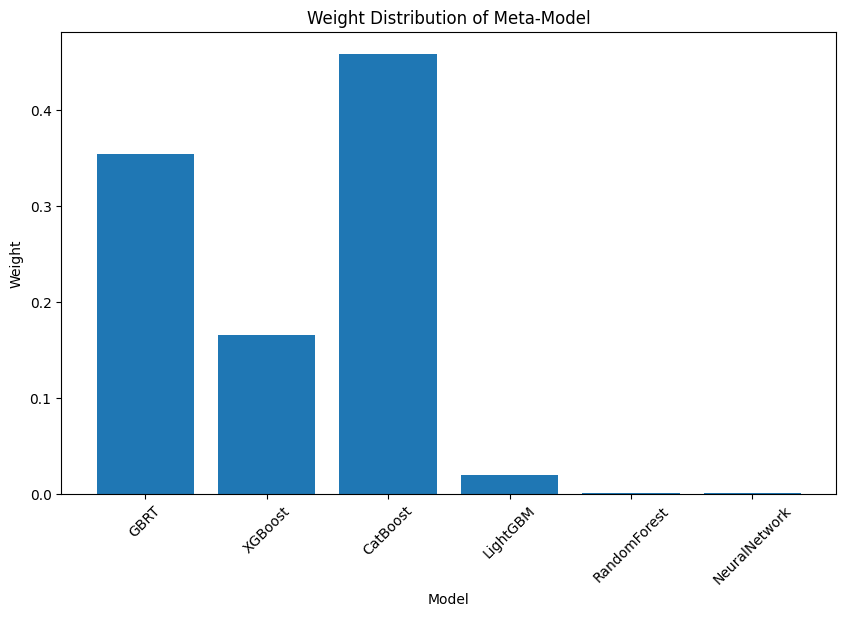

In [138]:
import matplotlib.pyplot as plt

# Train a meta-model (GBRT) on the weighted predictions
meta_model = GradientBoostingRegressor()
meta_model.fit(stacked_features, y_valid)

# Retrieve the feature importances
feature_importances = meta_model.feature_importances_

# Create a bar plot to visualize the weight distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=stacked_features.columns)
plt.xlabel('Model')
plt.ylabel('Weight')
plt.title('Weight Distribution of Meta-Model')
plt.xticks(rotation=45)
plt.show()

stacked regression (GBRT,XGB,CAT만 사용)

In [139]:
stacked_feature = pd.DataFrame({
    'GBRT': gbrt_preds,
    'XGBoost': xgb_preds,
    'CatBoost': catboost_preds
})

In [140]:
meta_model2 = GradientBoostingRegressor()
meta_model2.fit(stacked_feature, y_valid)

GradientBoostingRegressor()

In [142]:
y_pred =meta_model2.predict(stacked_feature)
mae = mean_absolute_error(y_valid, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 5.563139798381409


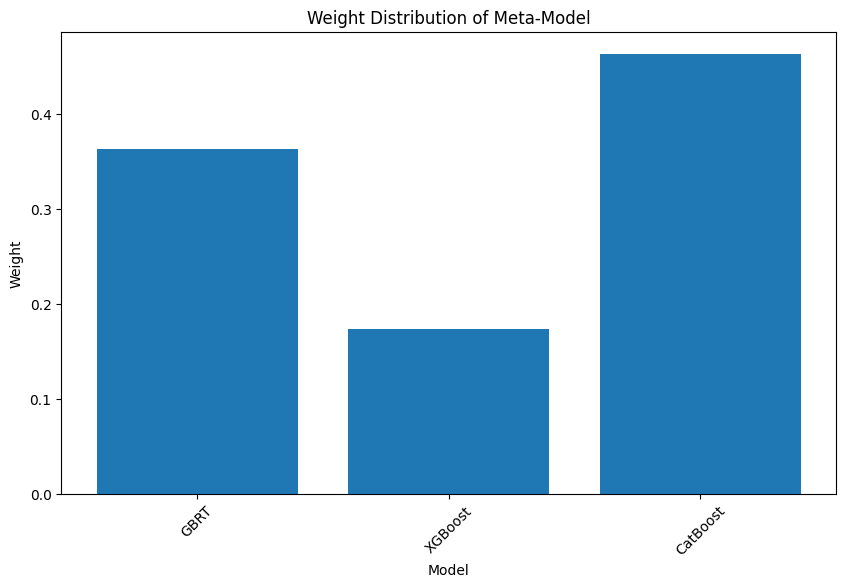

In [143]:
# Train a meta-model (GBRT) on the weighted predictions
meta_model2 = GradientBoostingRegressor()
meta_model2.fit(stacked_feature, y_valid)

# Retrieve the feature importances
feature_importances = meta_model2.feature_importances_

# Create a bar plot to visualize the weight distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=stacked_feature.columns)
plt.xlabel('Model')
plt.ylabel('Weight')
plt.title('Weight Distribution of Meta-Model')
plt.xticks(rotation=45)
plt.show()